In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import scipy as sp
from scipy import stats   
import statsmodels as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
import os
import json

%pylab inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# importing the data
nrg = pd.read_csv("https://raw.githubusercontent.com/sebscho/PUI2017_ses515/master/HW6_ses515/Data/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
bsize = pd.read_csv('https://raw.githubusercontent.com/sebscho/PUI2017_ses515/master/HW6_ses515/Data/MN.csv')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# bsize.columns
nrg=nrg[['BBL', 'Reported Property Floor Area (Building(s)) (ft²)','DOF Property Floor Area (Buildngs and Parking)(ft2)','DOF Number of Buildings', 'Site EUI(kBtu/ft2)', 'Postcode']].copy()

In [4]:
# bsize.columns
bsize = bsize[['BBL', 'YearBuilt', 'UnitsTotal', 'NumFloors','UnitsRes']].copy()

# Exploratory Analysis

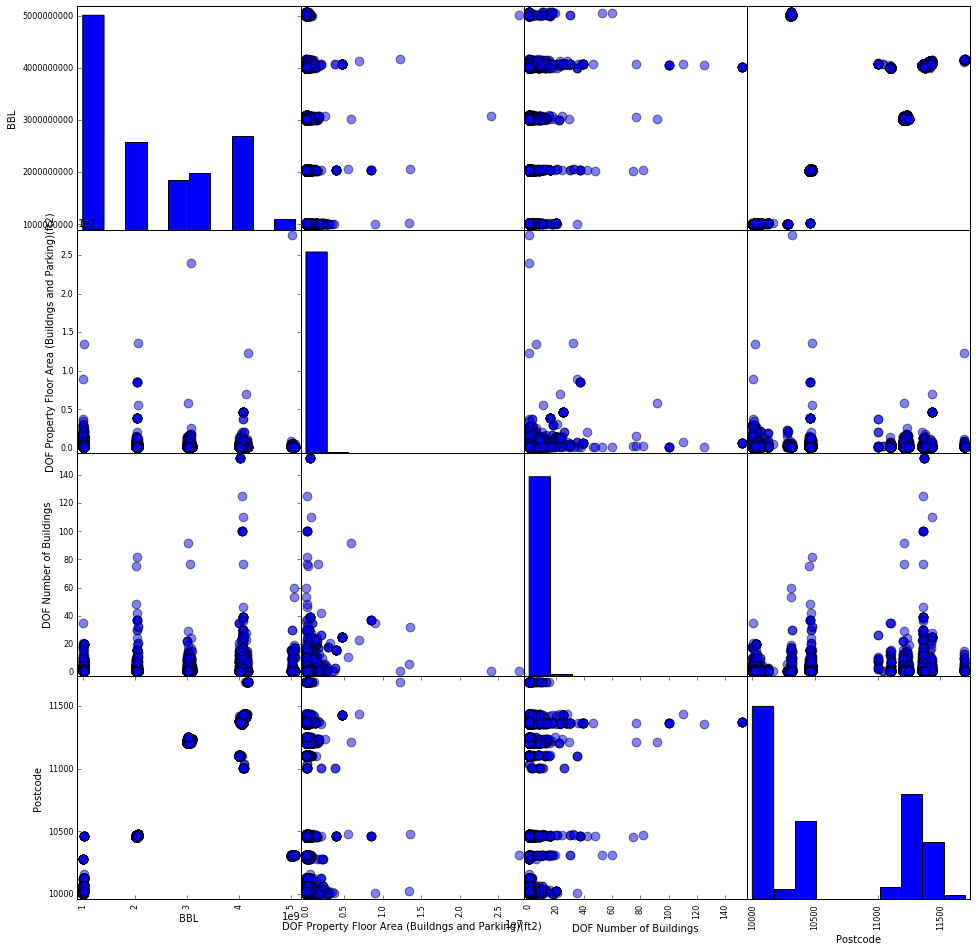

In [5]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));

**Fig1:** This scatter matrix looks for initail relationships between our variables in our dataset. 


In [6]:
# convert to numeric. coerce means that any value missing will become a nan.
nrg = nrg.apply(lambda x: pd.to_numeric(x, errors = 'coerce'))
bsize = bsize.apply(lambda x: pd.to_numeric(x, errors = 'coerce'))

In [7]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010010.0, 1000410001.0)

In [8]:
nrgmerge = nrg[['BBL', 'Reported Property Floor Area (Building(s)) (ft²)', 'Site EUI(kBtu/ft2)']].copy()

In [9]:
bblnrgdata = pd.merge(nrgmerge, bsize, on='BBL').dropna()
bblnrgdata.shape

(5085, 7)

# Energy vs Units

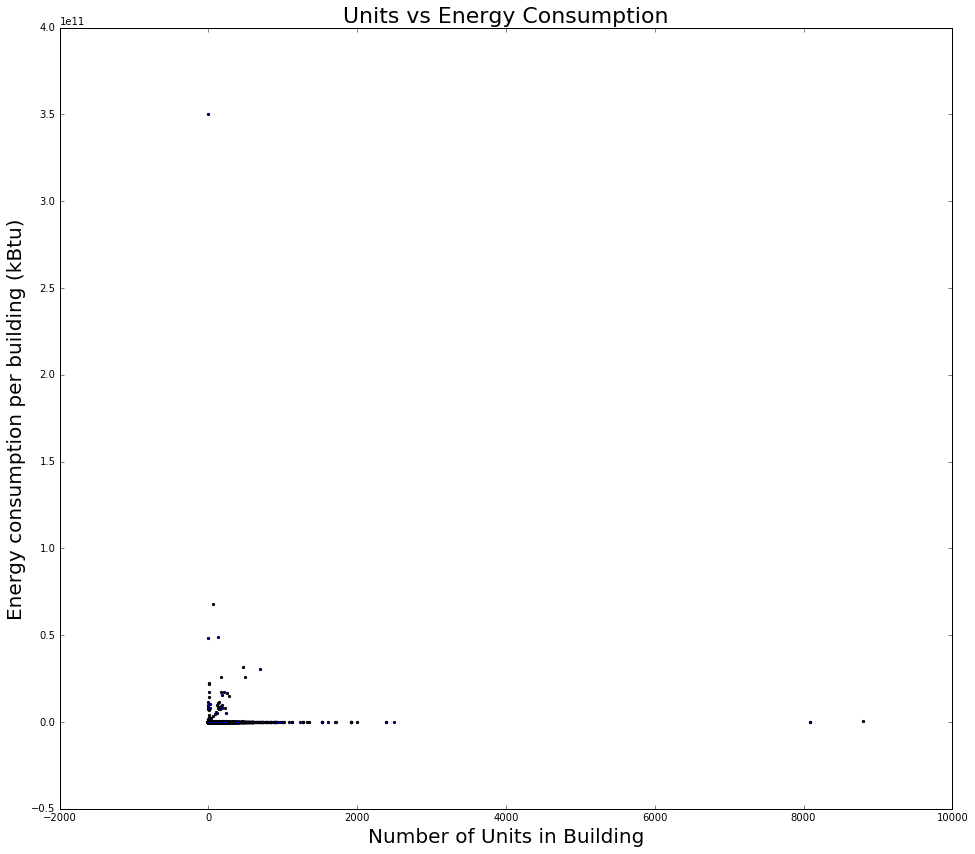

In [10]:
# creating a new column for total energy, found by multiplying floor area by site EUI
bblnrgdata['tot_energy'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'] * bblnrgdata['Site EUI(kBtu/ft2)']

ax = bblnrgdata.plot(kind='scatter', y='tot_energy', x='UnitsTotal', 
                   marker='.',  figsize=(16, 14))
y = ax.set_xlabel("Number of Units in Building", fontsize=20)
x = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title('Units vs Energy Consumption', fontsize=22)

**Fig 2:** Number of Units in Building vs. Energy consumption. This plot leaves room to be desired because all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. Let's see if we can clean it up. 

# Plot Energy vs Number of Units in the Buildings

In [11]:
# Doing this to help our pandas understand these names later on
bblnrgdata['Reported Property Floor Area (Building(s))'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']

# getting rid of the outliers
bblnrgdataCut = bblnrgdata[(bblnrgdata.tot_energy > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

//anaconda/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


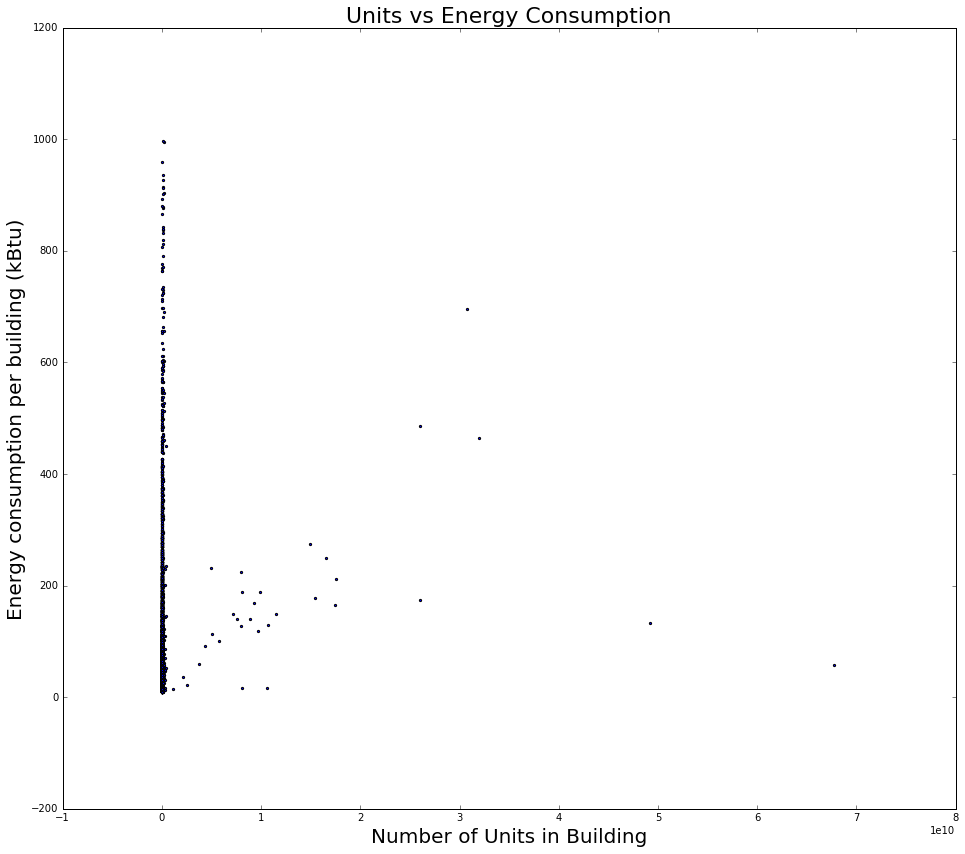

In [12]:
ax = bblnrgdataCut.plot(kind='scatter', x='tot_energy', y='UnitsTotal', 
                   marker='.',  figsize=(16, 14))
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title('Units vs Energy Consumption', fontsize=22)

**Fig 3:** Here, we've cut the dataset to feature the main data. This plot shows that there's a relationship, but we still can't tell exactly what. Next steps are to zoom in on the areas that we care about. 

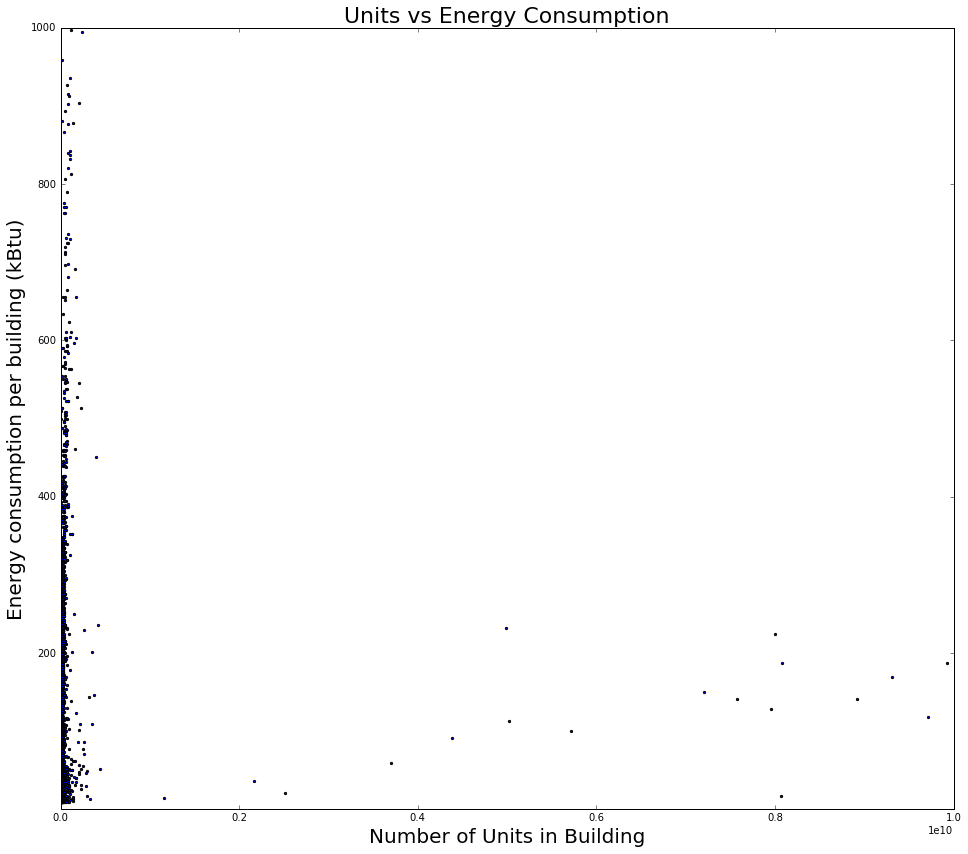

In [13]:
# adding xlims to zoom in

ax = bblnrgdataCut.plot(kind='scatter', x='tot_energy', y='UnitsTotal', 
                   marker='.',  figsize=(16, 14))
ax.set_xlabel("Number of Units in Building", fontsize=20)
ax.set_xlim(1000, 1e10)
ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_ylim(1, 1000)


ax.set_title('Units vs Energy Consumption', fontsize=22)

**Fig 4:**From here we can tell that a log might be the way to isolate what's going on here. If we do that, it will compress the high x and high y values, and expand the small x and small y values.

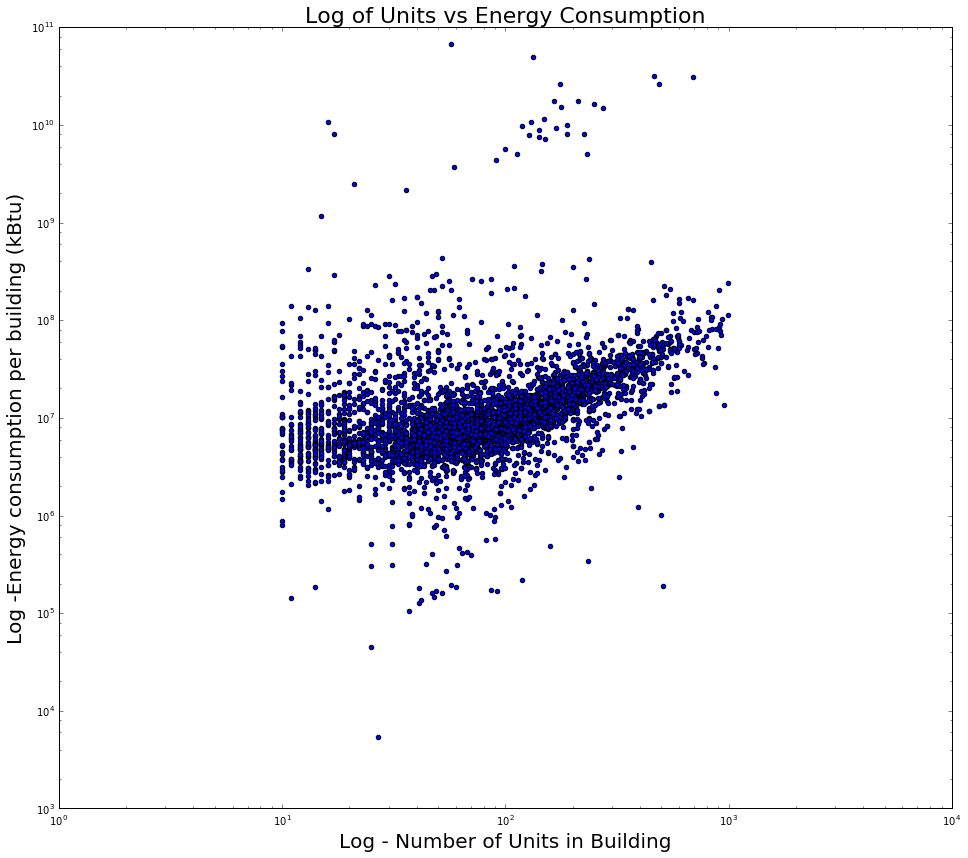

In [14]:
# loglog true beacuse we're trying to create a linear relationship that we can work with
# we're trying to observe some sort of relationship
ax = bblnrgdataCut.plot(kind='scatter', y='tot_energy', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Log - Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Log -Energy consumption per building (kBtu)", fontsize=20)
ax.set_title('Log of Units vs Energy Consumption', fontsize=22)

**Fig 5:** The log allows us to better see the relationship between number or units in the building and energy consumption per building. 

## Modeling

In [15]:
x = bblnrgdataCut['UnitsTotal']
y = bblnrgdataCut['tot_energy']

X = sm.add_constant(np.log10(x))

linmodel = sm.OLS(np.log10(y), X, missing='drop').fit()


In [16]:
X.head()

,const,UnitsTotal
2,1.0,1.748188
16,1.0,1.380211
18,1.0,1.380211
19,1.0,1.792392
20,1.0,1.929419


In [17]:
linmodel.params

const         6.108943
UnitsTotal    0.490372
dtype: float64

In [18]:
# grabs params and multiplies x by coef and adds the constant
# this is essentially doing "mx + b" for all values in the array
lm_y = linmodel.fittedvalues

## 1. Fitting line to Units vs Energy

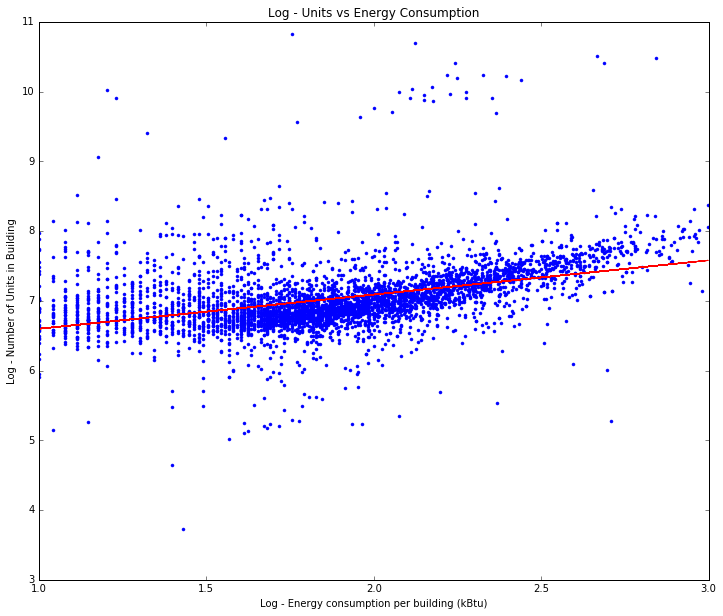

In [19]:
fig = plt.figure(figsize = (12,10))

# plotting x by y
plot(np.log10(x), np.log10(y), '.')

# plotting mx + b
# plot(np.log10(x), linmodel.params[1]*np.log10(x) + linmodel.params[0], c='r')

# or plotting with fitted values
plot(np.log10(x), lm_y, c = 'r')

pl.title('Log - Units vs Energy Consumption')
pl.xlabel('Log - Energy consumption per building (kBtu)')
pl.ylabel('Log - Number of Units in Building')


**Fig 6:** Here we see the linear model in red, along with our observed data. 

## 2. Fitting line to Energy to Units

In [20]:
x1 = bblnrgdataCut['tot_energy']
y1 = bblnrgdataCut['UnitsTotal']

X1 = sm.add_constant(np.log10(x1))

linmodel1 = sm.OLS(np.log10(y1), X1, missing='drop').fit()

In [21]:
lm1_y = linmodel1.fittedvalues

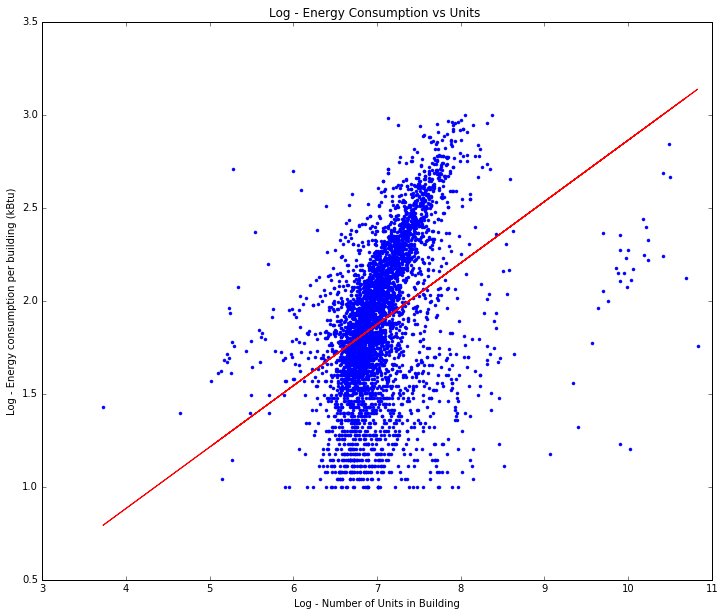

In [22]:
fig = plt.figure(figsize = (12,10))
# plotting x by y
plot(np.log10(x1), np.log10(y1), '.')
# plotting mx + b
plot(np.log10(x1), lm1_y, c='r')

pl.title('Log - Energy Consumption vs Units ')
pl.ylabel('Log - Energy consumption per building (kBtu)')
pl.xlabel('Log - Number of Units in Building')


**Fig 7:** This is the alternative relationship, flipping which is the dependent variable. How zany! 

## 3. Evaluate which model is better using Chi Square

In [23]:
# calculating errors
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s))'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)



In [24]:
# log of the errors
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.tot_energy / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))


In [25]:
def chi2(data, model, errors = None):
#     for i in range(len(obs)):
#         chi2 = chi2 + ((obs[i]-exp[i])**2)/(error[i]**2)
#     return chi2
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [26]:
print("Chi2 of Units vs. Energy is: " + str(chi2(np.log10(bblnrgdataCut['UnitsTotal']), lm_y, errorsInLogUnits)))
print("Chi2 of Energy vs. Units is: " + str(chi2(np.log10(bblnrgdataCut['tot_energy']), lm1_y, errorsInLogNrg)))
print ("Results: Chi2 of Units vs. Energy is much lower, as we would expect from the scatter plots")

Chi2 of Units vs. Energy is: 65564901.8998
Chi2 of Energy vs. Units is: 2.15151137717e+13
Results: Chi2 of Units vs. Energy is much lower, as we would expect from the scatter plots


## Fit a 2nd degree polynomial to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is  $y = ax^2 + bx + c$ .

In [27]:
dflog = np.log10(bblnrgdataCut[['UnitsTotal', 'tot_energy']])
dflog.head()

,UnitsTotal,tot_energy
2,1.748188,7.616811
16,1.380211,7.629287
18,1.380211,7.286094
19,1.792392,6.950549
20,1.929419,6.811909


In [28]:
qm = smf.ols(formula="tot_energy ~ I(UnitsTotal**2) + UnitsTotal", data = dflog)
qmmodel = qm.fit()
qmmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tot_energy   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     612.9
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          8.24e-235
Time:                        23:51:19   Log-Likelihood:                -2444.1
No. Observations:                4285   AIC:                             4894.
Df Residuals:                    4282   BIC:                             4913.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              8.0731      0.112     72.104      0.000         7.854     8.293
I(UnitsTotal ** 2)     0.5682      0.031     18.288      0.000         0.507     0.629
UnitsTotal            -1.6706      0.119    -14.003      0.000        -1.905    -1.437
==============================================================================
Omnibus:                     2423.017   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57853.466
Skew:                           2.219   Prob(JB):                         0.00
Kurtosis:                      20.445   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

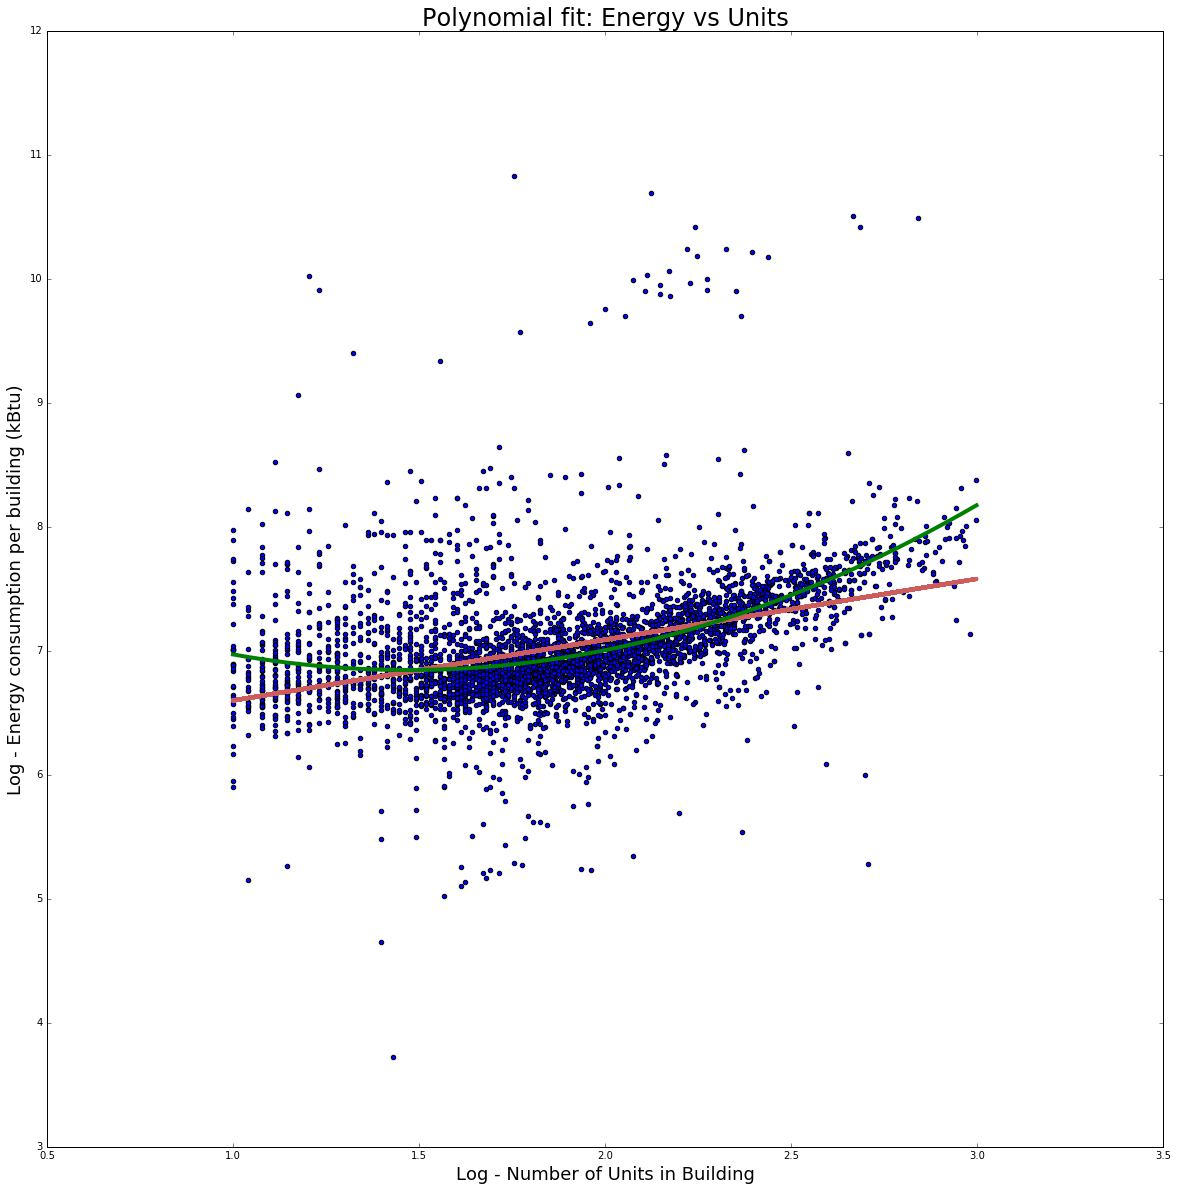

In [29]:

# the data
ax = dflog.plot(x='UnitsTotal', y='tot_energy', kind='scatter', figsize=(20,20))

# linmodel fit line
ax.plot(np.log10(x), lm_y, color="IndianRed", linewidth=4.0)

# sorted quad model fit
df1_ = dflog.sort_values(by='UnitsTotal')
ax.plot(df1_.UnitsTotal, qmmodel.predict(df1_), '-', color='g', linewidth=4.0)

pl.title('Polynomial fit: Energy vs Units', fontsize=24)
pl.ylabel('Log - Energy consumption per building (kBtu)', fontsize=18)
pl.xlabel('Log - Number of Units in Building', fontsize=18)


**Fig 8:** This shows both the quadratic and linear fits to the data. We can see that the quadratic line appears to fit better. However, we don't want to risk overfitting by adding an additional parameter unless it's really adding something special. Let's do the Likelihood Ratio Test to determine if adding the extra parameter is worth it. 

## Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test.

In [30]:
print ("params:" + str(qmmodel.compare_lr_test(linmodel)))

params:(322.25132713541007, 4.6829415120327037e-72, 1.0)


** Interpreting the null:** The null hypothesis for this test says that the simpler model is as good or better than the more complex model. If we reject the null, we should use the model with more parameters. Since our statistic is larger than p at chosen significance level of .05, we can reject the null. The quadratic equation is best. 


# Extra Credit 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


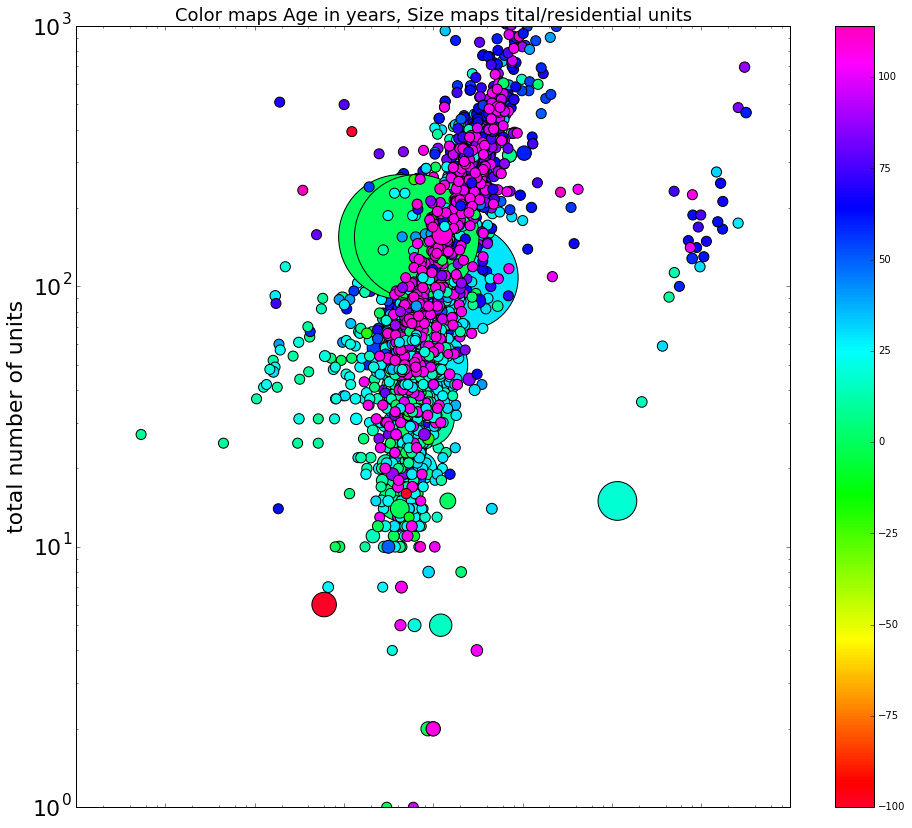

In [31]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='tot_energy',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)